Title Name:

By: (our names)


The following report aims to explore whether played hours and gender can accurately predict subscription. The data observed is from a research group in Computer Science at UBC, exploring how people play video games. Players' navigation of the world is recorded. The team created 2 CSVs - players.csv, observing unique players and data about them, and sessions.csv, observing individual sessions and information about the session. Purpose of study: to target recruitment efforts. This report regards data from players.csv. Specifically, we wish to answer the question: Can played hours predict subscription in players.csv?


Players.csv (196 rows) 
- 7 (explored) columns: 
  - 2 decimal:
    - Age (of user) 
    - played_hours (indicating users' hours played). 
  - 3 character:
    - experience (specifies user gaming experience - pro, veteran, amateur, regular, beginner)
    - name
    - gender (male, female, prefer not to say, non-binary, other, two-spirited, agender).
    - hashedEmail (email of user - hashed) -b one per player
  - 1 logical:  
    - Subscribe (indicates whether user is subscribed to game newsletter - TRUE/FALSE). 


**Justification:**
- played hours has relationship with subscription (further observed below).
- Gender seen to have a relationship with subscription (further observed below). 

In [39]:
library(tidyverse)
library(dplyr)
library(tidymodels)

In [40]:
url <- "https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players <- read_csv(url)
head(players)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


**Wrangled Data** - NA's removed(as they skew data) and subscribe variable turned into a factor as that is the response variable in our classification question. Also renamed Age to age and hashedEmail to hashed_email for clarity (matching trend).

In [41]:
players <- players |>
    select(experience, subscribe, hashedEmail, played_hours, name, gender, age) |>
    drop_na() |>
    mutate(subscribe = as.factor(subscribe)) |>
    rename(hashed_email=hashedEmail)

head(players)

experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


## **Relevant Summary Statistics**

## Context

**Subscribe:** We need to oversample rare class (FALSE) in prediction due to inbalances in our response variable

In [42]:
subscribe_count <- players|>
count(subscribe)

subscribe_count

subscribe,n
<fct>,<int>
FALSE,52
TRUE,144


**Gender:** Mostly males, followed by females. Unequal distribution. Therefore, we are looking at this predictor by rate subscribed rather than just quantity. 

In [43]:
gender_count <- players |>
  count(gender)

gender_count

gender,n
<chr>,<int>
Agender,2
Female,37
Male,124
Non-binary,15
Other,1
Prefer not to say,11
Two-Spirited,6


**Played Hours:** 85/196 played 0 hours - raises concern. 

In [44]:
played_hours_count <- players|>
count(played_hours)

head(played_hours_count)

played_hours,n
<dbl>,<int>
0.0,85
0.1,34
0.2,10
0.3,5
0.4,5
0.5,4


## Justification

Proportion data computed to understand the counts better, accounts for category imbalances - relevant for graphs.

In [45]:
ratio_gender_subscribed <- players |>
  group_by(gender) |>
  summarize(
    total = n(),
    subscribed = sum(subscribe == TRUE),
    percentage_subscribed = (subscribed / total)*100)


ratio_gender_subscribed

gender,total,subscribed,percentage_subscribed
<chr>,<int>,<int>,<dbl>
Agender,2,2,100.00000
Female,37,29,78.37838
Male,124,93,75.00000
Non-binary,15,11,73.33333
Other,1,1,100.00000
Prefer not to say,11,4,36.36364
Two-Spirited,6,4,66.66667


Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


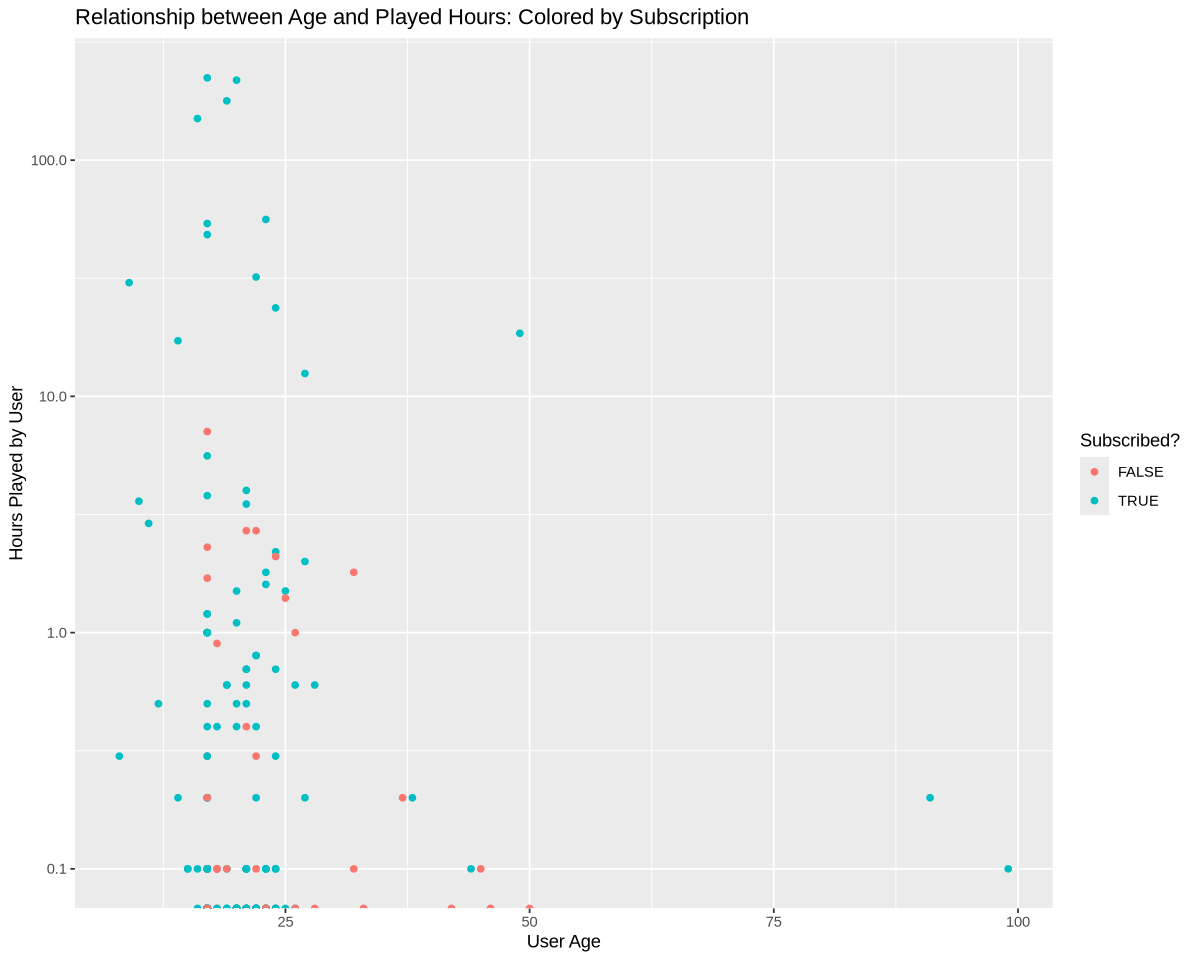

In [46]:
age_vs_played_hours <- players|>ggplot(aes(x=age, y=played_hours, color=subscribe))+
geom_point() +
scale_y_log10() +
labs(x="User Age", y="Hours Played by User", color="Subscribed?")+
ggtitle("Relationship between Age and Played Hours: Colored by Subscription")

age_vs_played_hours

Age vs played_hours, color by subscribed. 
- Age does not have a relationship with subscription
- More data points for younger players (>25).
-  Higher played hours correlate with subscription (all >10 = subscribed).
- Played hours likely predictive of subscription.
- Limitation of played hours is the unequal distribution of data (85/196 are at 0 played hours), but since it is the only quantitative variable with a relationship to subscription in the players dataset, it will be used as a predictor. 

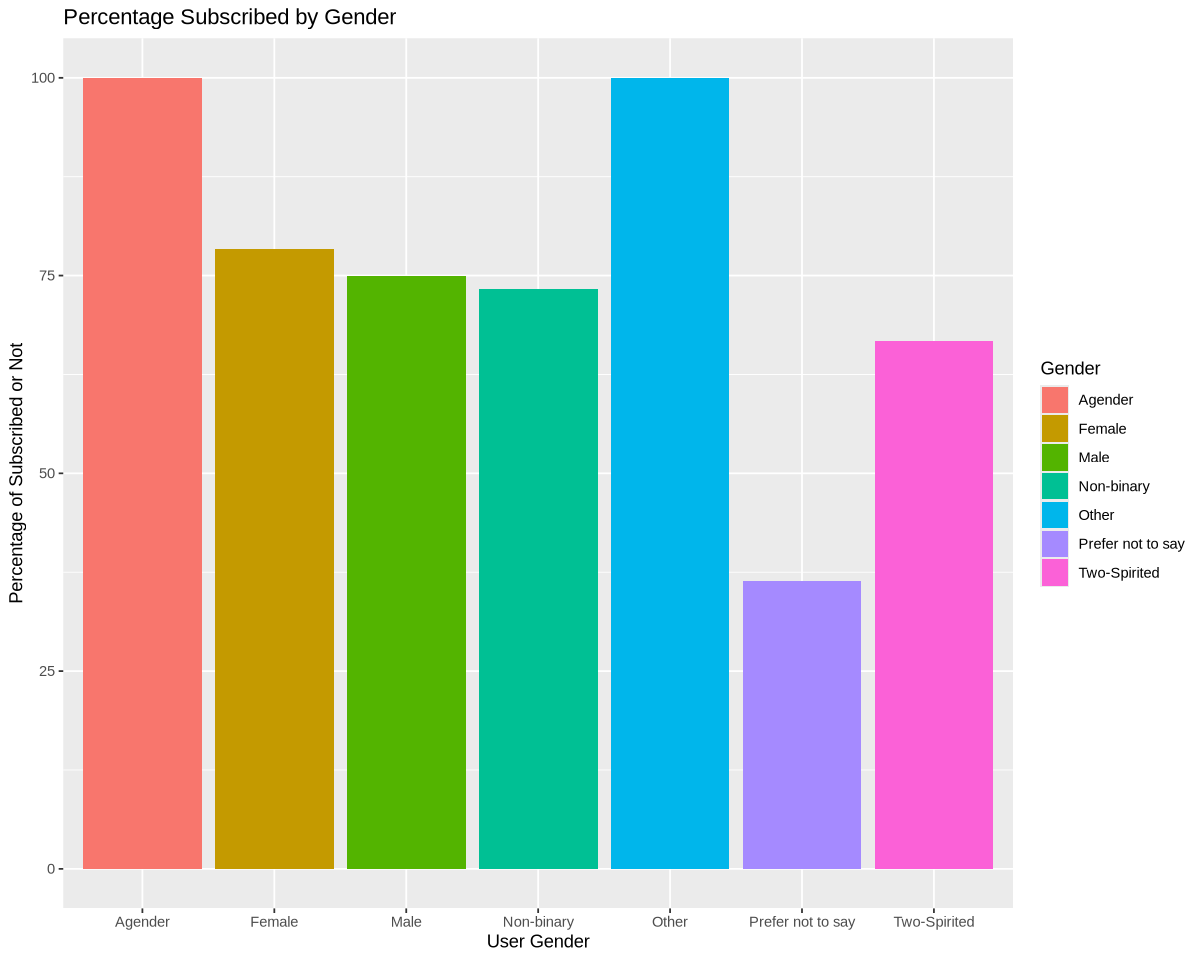

In [47]:
gender_subscribed_ratio_bar <- ratio_gender_subscribed|>ggplot(aes(x=gender, y=percentage_subscribed, fill=gender))+
geom_bar(stat="identity") +
labs(x="User Gender", y="Percentage of Subscribed or Not", fill="Gender")+
ggtitle("Percentage Subscribed by Gender")


gender_subscribed_ratio_bar

Percentage subscribed by gender - women have a highest subscription rate.
- Small-category sizes limit inference.
- Data limitations prevalent ( limited data for agender and other).
- Change in the dominating gender observed when looking at proportion instead of count.
- Likely a predictive variable.

As seen above, played_hours and gender is indicative of subscription - Looking at percentages subscribed by genders proves that it is not just predictive of subscription due to limited data points. 

In [48]:
players_encoded <- players |>
        mutate(gender_male = ifelse(gender == "Male", 1, 0),
               gender_female = ifelse(gender == "Female", 1, 0),
               gender_nb = ifelse(gender == "Non-binary", 1, 0),
               gender_na = ifelse(gender == "Prefer not to say", 1, 0),
               gender_ts = ifelse(gender == "Two-Spirited", 1, 0),
               gender_agender = ifelse(gender == "Agender", 1, 0))

In [49]:
players_split<- initial_split(players_encoded, prop=0.7, strata=subscribe)
players_training <- training(players_split)
players_testing <- testing(players_split)

In [50]:
players_recipe <- recipe(subscribe~gender_male + gender_female + gender_nb + gender_na + gender_ts + gender_agender + played_hours, data=players_training) |>
step_scale(all_predictors()) |>
step_center(all_predictors())

In [51]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [52]:
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))
players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

In [53]:
players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- players_fit |>
  filter(.metric == "accuracy")

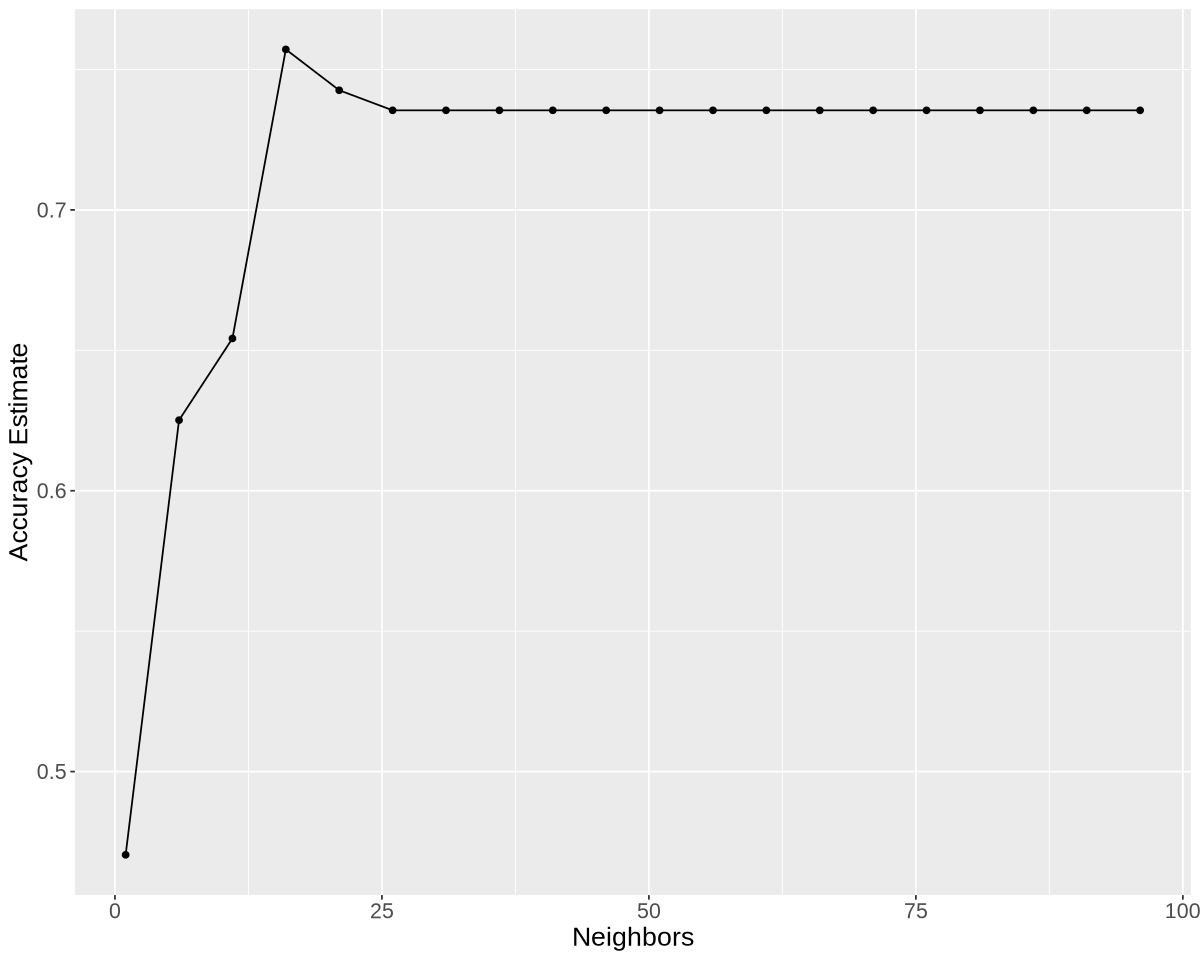

In [54]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 16))

accuracy_vs_k

In [55]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 16

# **Discussion**

We found that gender and played_hours are/ are not predictive of subscription. We originally expected to find... Such findings can help the UBC Computer Science team conducting this research understand... Our next question is whether gender is more predictive than played hours or vice versa? Additionally, it is important to 


summarize what you found
discuss whether this is what you expected to find
discuss what impact could such findings have
discuss what future questions could this lead to